# En este ejercicio vamos a vectorizar textos y entrenar un resolvedor de tickets.#

<div class="alert alert-block alert-info">
El procesamiento del lenguage natural tiene, entre otros usos : 
<br><br>

 - Construcción de **modelos de ML** cuya entrada es texto libre.<br>
 - **Extracción de tópicos** de un texto.<br>
 - **Auto clasificación** de textos.<br>
 - **Analisis sentiente**.<br>
 - **Traducción** entre idiomas.<br>
<br>
</div>

 
Vamos a construir un predictor de tickets, que dado un ticket nuevo con una incidencia, lo categoriza.

## Fases
- ### Carga del dataset y de las stop words
- ### Preprocesado.
- ### Vectorización del dataset con CountVectorizer.
- ### Transformación del dataset.
- ### Comparativa de clasificadores con kfold.

- ### Bonus: 

## Carga del dataset 


In [ ]:
import sys
import IPython
import numpy as np
import pandas as pd
import sklearn as sk


import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# Load data
df = pd.read_csv("datasets/tickets-jobs.csv")



df.head(2)

### Instalamos las stop words###


Las stop words son palabras que no añaden significado a un texto (pronombres, interjecciones, frases hechas)


In [2]:
!pip install stop-words

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from stop_words import get_stop_words
##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
stop  = get_stop_words('spanish') + get_stop_words('english')

print(stop)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

## Preprocesado ##

Quitamos : 
 - casos demasiados infrecuentes, 
 - columnas vacias,  
además, concatenamos el campo "Asunto" y "Cuerpo" de los tickets.



In [4]:
import pandas as pd
NUM_TICKETS=1000

# Preprocess
CASES_TO_DELETE=["Problem" ,
                 "artifactory-permisos",
                 "integration-dcip-github",
                 "restart-VM",
                 "artifactory-add-user-grupo",
                 "artifactory-add-repo-local",
                 "crear-maquina-virtual" , "un", "Otros"]


for case in CASES_TO_DELETE : df = df.drop(df[df.problem == case].index)
    
df["problem"][df.problem == "unsuspend"] = "unsuspend-pdihub-user" 

# Cargamos DF
df.dropna(subset = ['problem'],inplace=True) 

print("Tipos de problemas, y conteo de tickets por problema")
print(df.problem.value_counts())



try:
    # Quitamos los campos vacios
    df['subject'].fillna('', inplace=True)
    df['content'].fillna('', inplace=True)
    
    # Un solo campo concatenando Subject + Content
    df["ticket"] = df['content'] + df['subject']

except: pass


try:
    # Borrar columnas
    del df['content'] 
    del df['subject']
except: pass



import matplotlib.pyplot as plt

CountStatus = pd.value_counts(df['problem'].values, sort=True)
CountStatus.plot.barh()

df.tail(4)


Tipos de problemas, y conteo de tickets por problema
unsuspend-pdihub-user       102
add-github-user              76
add-pdihub-user              56
add-users-to-tenant-kilo     34
add-jira-user                31
add-users-to-tenant          31
create-wiki                  23
crearmaquinavirtual          21
add-ftp-user                 20
Name: problem, dtype: int64


,id,problem,ticket
714,226651,unsuspend-pdihub-user,Buenos dias Mi usuario art has sido marcado co...
715,226624,add-github-user,Buenos dias He perdido el acceso al repositori...
717,226615,unsuspend-pdihub-user,Estimados Desde el problema suscitado hace un ...
722,226586,crearmaquinavirtual,Hola de cara a poder instalar una maquina para...


## Vectorización del dataset con CountVectorizer.
<br>
<div class="alert alert-block alert-info">
<br>
**Vectorizar** es pasar el lenguage natural a un conjunto de vectores, donde cada palabra o grupo de palabras es un punto en un espacio n-dimensional. <br><br>

Viene a ser como si tradujeramos el texto a otro lenguage, salvo que ese lenguaje son números.<br><br>

La ventaja de traducirlo a números, es que puedes realizar operaciones matemáticas con el lenguage, en este caso, entrenar un modelo de ML.
</div>

Normalmente para generar el dataset el procedimiento es stopword + stemming (quitar plurales) + bag of words.<br> <br> 
En este caso, vamos a usar [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), el cual en un solo paso:<br> 
 - aplica las stop words, 
 - genera los n-grams (agrupa palabras en grupos de n)
 - cuenta las frecuencias, para generar las features.

El resultado es un dataset cuyas columnas son los n-gramas mas frecuentes, la fila es cada uno de los ticket y cada celda es la frecuencia de ese n-grama en ese ticket.

In [5]:
# CountVectorizer implements both tokenization and occurrence counting
#  in a single class:
MAX_FEATURES=100

from sklearn.feature_extraction.text import CountVectorizer
### 
count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))

X = count.fit_transform(df['ticket'].values)
print(count)
print(X.toarray()  , X.shape , X[0].shape  )


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=100, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'e..."wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [5 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (394, 100) (1, 100)


Eso son los ngramas mas frecuentes, que han resultado en features.

In [6]:
print(count.get_feature_names())



['activity', 'antonio', 'asunto', 'aura', 'borja', 'buenas tardes', 'cid', 'cid image', 'cid image png', 'cloud', 'cloud eu', 'cloud eu mad', 'com asunto', 'com signature', 'comunicacion', 'comunicacion madrid', 'copia', 'correo', 'cuenta pdihub', 'datos', 'david', 'david peralesferreratelefonica', 'david peralesferreratelefonica com', 'destinatario', 'dev', 'distrito telefonica', 'dormant', 'enviado', 'epgtid', 'error', 'eu', 'eu mad', 'eu mad instantservers', 'francisco', 'ftp', 'garcia', 'gb', 'gif', 'github telefonica', 'gomez', 'gracias saludos', 'hola necesitamos', 'http', 'http www', 'https pdihub', 'https pdihub hi', 'image', 'image png', 'informacion', 'instantservers', 'instantservers telefonica', 'instantservers telefonica com', 'javier', 'jose', 'lourdes', 'luis', 'mad', 'mad instantservers', 'mad instantservers telefonica', 'manager', 'maquina', 'marcos', 'mismo', 'muchas gracias saludo', 'necesitaria', 'nombre', 'nueva', 'oeste', 'openstack', 'organizacion telefonica', 'o

## Transformación del dataset.


- Generamos un dataset a partir del CountVectorizer, por legibilidad.
(Por defecto utiliza un formato optimizado memoria que se llama sparse matrix, donde solo se representan los 1, y no los 0.)


In [7]:
from pandas import DataFrame

df_vectorizado = DataFrame(X.A, columns=count.get_feature_names() ) 

df_vectorizado = df_vectorizado.astype(bool).astype(int)

# Añadimos el campo problem, que sera el campo a predecir
df_vectorizado["problem"] = df["problem"] 
df_vectorizado["id"] = df["id"] 
df_vectorizado.dropna(subset = ['problem'],inplace=True) 

df_vectorizado.head()


,activity,antonio,asunto,aura,borja,buenas tardes,cid,cid image,cid image png,cloud,...,telefonica com,telefonica com signature,telefonica github,tener,usuario github,video,wiki,www,problem,id
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,add-ftp-user,169515.0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,create-wiki,169982.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,crearmaquinavirtual,170229.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,create-wiki,170397.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,create-wiki,171179.0


In [8]:
## Generamos X e Y, para entrenar los modelos

In [9]:
from sklearn.preprocessing import LabelEncoder
import sys

try             : del df_vectorizado["id"] 
except Exception: pass

y = df_vectorizado.iloc[:,-1]
X = df_vectorizado.drop('problem', axis=1)

y.head()




0           add-ftp-user
1            create-wiki
2    crearmaquinavirtual
3            create-wiki
4            create-wiki
Name: problem, dtype: object

In [10]:
X.head()

,activity,antonio,asunto,aura,borja,buenas tardes,cid,cid image,cid image png,cloud,...,tardes,teams,telefonica com,telefonica com signature,telefonica github,tener,usuario github,video,wiki,www
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
y.head()

0           add-ftp-user
1            create-wiki
2    crearmaquinavirtual
3            create-wiki
4            create-wiki
Name: problem, dtype: object

## Comparativa de clasificadores con kfold.

Como en el ejercicio anterior, probamos una bateria de modelos y validamos su score con k-fold.


In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

NUM_SPLITS=8

kfold = KFold(n_splits=NUM_SPLITS)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     random_state=1)
    
    
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
         "MLPClassifier", 
         "AdaBoost",
         "XGBoost" 
        ]


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    XGBClassifier()
]


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores = model_selection.cross_val_score(clf, X, y,  cv=kfold )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name))
    score = clf.score(X_test, y_test)

# Practicamos tambien el voto de algoritmos, por si fuera mas preciso
eclf = EnsembleVoteClassifier(clfs=classifiers, 
                              weights=[1,1,1,1,1,1,1,1])
scores = model_selection.cross_val_score(eclf, X, y,  cv=kfold )
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), "EnsembleVoteClassifier"))
  
print("Fin")




Accuracy: 0.21 (+/- 0.10) [Nearest Neighbors]
Accuracy: 0.22 (+/- 0.18) [Linear SVM]
Accuracy: 0.22 (+/- 0.15) [RBF SVM]
Accuracy: 0.30 (+/- 0.09) [Decision Tree]
Accuracy: 0.20 (+/- 0.09) [Random Forest]
Accuracy: 0.25 (+/- 0.12) [MLPClassifier]
Accuracy: 0.20 (+/- 0.09) [AdaBoost]
Accuracy: 0.26 (+/- 0.16) [XGBoost]
Accuracy: 0.31 (+/- 0.11) [EnsembleVoteClassifier]
Fin


(261, 2)


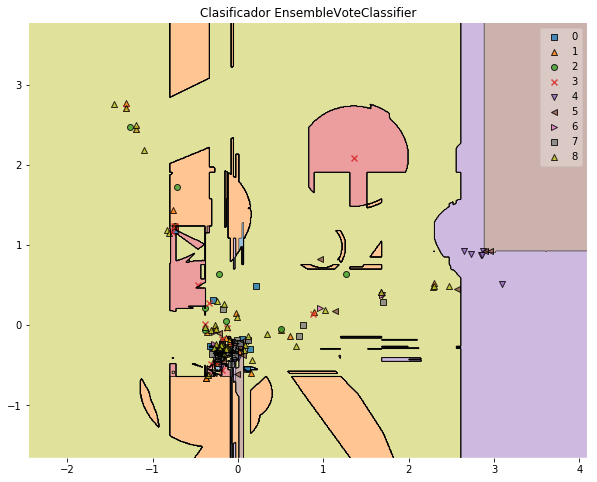

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA



le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2

#print(X,y)

###### Generamos un nuevo dataframe con solo dos componentes.
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X)
print(X_pca_2c.shape)


pca_2c.explained_variance_ratio_.sum()

###### Miramos el gráfico
from sklearn.naive_bayes import GaussianNB 
from mlxtend.plotting import plot_decision_regions



X     = X_pca_2c
model = eclf  
clf   = model
clf.fit(X, y)

# Generamos el gráfico
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X, y=y, clf=clf)


plt.title("Clasificador EnsembleVoteClassifier")




## Bonus : Vectorización con TF-IDF

Vamos a utilizar otro vectorizador, usada para extraer tópicos relevantes un conjunto de texto, TfidfVectorizer.
<br>
<div class="alert alert-block alert-info">

Tf-idf (del inglés Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos)<br><br>Es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.</div>



In [14]:

MAX_FEATURES=100

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))

X = count.fit_transform(df['ticket'].values)
print( X.shape , X[0].shape  )

from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_train_tf = tf_transformer.transform(X)
X_train_tf.shape
X_train_tf




(394, 100) (1, 100)


<394x100 sparse matrix of type '<class 'numpy.float64'>'
	with 2042 stored elements in Compressed Sparse Row format>

Primero vectorizamos con el **TfidfVectorizer**
Vemos que el dataframe sale distinto, que con el **CountVectorizer**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np




tf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,3),
                     max_features=MAX_FEATURES,
                     min_df = 0, 
                     stop_words = stop, 
                     sublinear_tf=True)

X_train_tf =  tf.fit_transform(df['ticket'].values)

tf_transformer = TfidfTransformer(use_idf=False).fit(X)
feature_names = tf.get_feature_names()

X = tf.fit_transform(df['ticket'].values)


    

df_vectorizado = DataFrame(X.A, columns=tf.get_feature_names() ) 
df_vectorizado_short =DataFrame(X.A, columns=tf.get_feature_names() ) 

# Añadimos el campo problem, que sera el campo a predecir
df_vectorizado["problem"] = df["problem"] 

df_vectorizado["id"] = df["id"] 
df_vectorizado.dropna(subset = ['problem'],inplace=True) 

print(df_vectorizado.shape)
df_vectorizado

(261, 102)


,acceder,acceso,activity,alta,alta usuario,asunto,borja,buenas,buenos,buenos dias,...,telefonica com signature,tenant,tid,user,usuario,usuarios,wiki,www,problem,id
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216786,0.000000,0.000000,...,0.0,0.000000,0.356538,0.000000,0.101935,0.000000,0.000000,0.000000,add-ftp-user,169515.0
1,0.183976,0.383547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.452185,0.000000,0.083885,0.198419,0.484695,0.000000,create-wiki,169982.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,crearmaquinavirtual,170229.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.195321,0.000000,0.000000,0.000000,0.440768,0.440768,create-wiki,170397.0
4,0.000000,0.123961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146058,0.146058,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.461480,0.000000,create-wiki,171179.0
5,0.363357,0.257141,0.000000,0.000000,0.000000,0.000000,0.000000,0.352339,0.000000,0.000000,...,0.0,0.000000,0.342248,0.000000,0.165674,0.000000,0.000000,0.000000,add-users-to-tenant,171347.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,crearmaquinavirtual,171384.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.508902,0.000000,0.000000,0.000000,0.000000,add-users-to-tenant,171578.0
8,0.000000,0.442690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.384421,0.168457,0.000000,0.000000,0.000000,add-users-to-tenant,172094.0
9,0.000000,0.305618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.196907,0.000000,0.000000,0.000000,add-users-to-tenant,173104.0


Usamos como Clasificador el [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). <br>Este clasificador es específico para el cálculo de frencuencia del conteo de palabras.



In [16]:
name="MultinomialNB"
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
# Display shapes
X_train
y_train

X = df_vectorizado_short.values
y = df["problem"] 

print(X.shape,y.shape)
scores = model_selection.cross_val_score(clf, X, y,  cv=kfold )
print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name))


print("Fin")


(394, 100) (394,)
Accuracy: 0.63 (+/- 0.30) [MultinomialNB]
Fin


In [17]:
Vemos que hemos obtenido una precisión muy alta.
Visualizamos el gráfico

SyntaxError: invalid syntax (<ipython-input-17-2e62acc9d986>, line 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


X = df_vectorizado_short.values
y = df["problem"]

le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2



###### Generamos un nuevo dataframe con solo dos componentes.
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X)


pca_2c.explained_variance_ratio_.sum()

###### Miramos el gráfico
from mlxtend.plotting import plot_decision_regions

X     = X_pca_2c

# Transformamos el intervalo de (-1,1) a (0,1000), porque el PCA te lo da valores normalizados,
# pero el MultinomialNB no admite frecuencias negativas de palabras. 
X=X+1
X=X * 10000
clf = MultinomialNB()
clf.fit(X, y)

print ("Sizes are : ", X.shape, y.shape, type(X), type(y),X[0] )

# Generamos el gráfico
#
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X, y=y, clf=clf)


plt.title("Clasificador Multinomial Naive Bayes")





Hacemos unos cuantos ejemplos de nuestro resolvedor de tickets.

In [ ]:
from IPython.display import display, HTML


 


docs_new = ['Quiero una wiki', 
            'Tengo suspendido mi usuario de pdihub',
            "Me gustaria añadir un usuario a mi tenant de openstack kilo",
            "Necesito un usuario para un nuevo proyecto en jira",
            "Quiero solicitar una maquina virtual nueva de vmware",
            "Necesito usar el ftp de ftp.tid.es",
            "Apuntame una licencia para github , para la organización de Aura ."]



X = df_vectorizado_short.values
y = df["problem"]


clf = MultinomialNB()
clf.fit(X, y)

X_new_counts = count.transform(docs_new)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)


# Cabecera de la tabla
s = f"""
  <h1> Pruebas de textos</h1> 
  <table>
    <tr>
      <th>Ticket</th>
      <th>Caso predicho</th>
    </tr>"""
    
# Cuerpo de la tabla
for doc, category in zip(docs_new, predicted):
   # Cuerpo de la tabla
    s = s + f"""
        <tr>
          <td>{doc}</td>
          <td>{category}</td>
        </tr>"""

# Pie de la tabla
s = s + f"""</table><br>"""


display(HTML(s))



